In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
from lib import dwt, huffman, ezw, size_amp, enc_dec, entropy

In [2]:
# define var
img_path = 'data/lena.bmp'
quant_step = 10

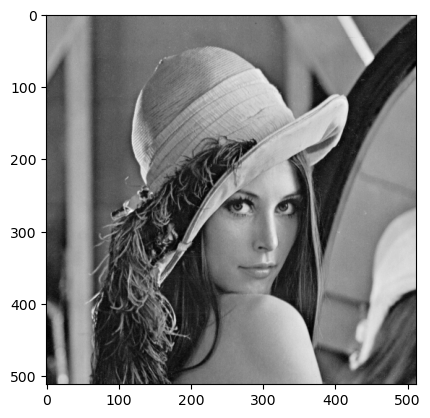

In [3]:
# open /home/fanqy/research-temp/eee5347/final-project/image1.512
with open('/home/fanqy/research-temp/eee5347/final-project/img/image1.512', 'rb') as f:
    data = f.read()
    data = list(data)
    # reshape data to numpy 512x512
    data = np.array(data)
    img = data.reshape((512, 512))
    plt.imshow(img, cmap='gray')


In [4]:
# decomp
l5_decomp = dwt.decomposition_to_specify_level(img, 5)

In [5]:
# quant
l5_decomp_quant = np.round(l5_decomp / quant_step)

In [6]:
# ezw_encode
# enumerate the img[0,16:0,16]
root_nodes = [[None for _ in range(16)] for _ in range(16)]
for i in range(0, 16):
    for j in range(0, 16):
        # in order of quadrant 1,3,4
        child_1 = ezw.build_tree(l5_decomp_quant, 1, (i,j+16), 1, None)
        child_3 = ezw.build_tree(l5_decomp_quant, 1, (i+16,j), 3, None)
        child_4 = ezw.build_tree(l5_decomp_quant, 1, (i+16,j+16), 4, None)
        root_nodes[i][j] = ezw.EZWTree(l5_decomp_quant[i, j], 0, 2, (i,j), [child_1, child_3, child_4], None) # type: ignore
        child_1.parent = root_nodes[i][j] # type: ignore
        child_3.parent = root_nodes[i][j] # type: ignore
        child_4.parent = root_nodes[i][j] # type: ignore

In [7]:
dpr_list= ezw.enc_dp_sp(root_nodes)

In [8]:
# size amplitude representation
result_size = []
result_amplitude = []
for i in range(16):
    for j in range(16):
        rs, ra = size_amp.size_amplitude_single_list(dpr_list[i][j])
        result_size = result_size + rs
        result_amplitude = result_amplitude + ra

result_amplitude_str_lf = ''.join(str(i) for i in result_amplitude)

In [9]:
# encode the top 16*16
top_16_16 = l5_decomp_quant[0:16, 0:16].flatten().astype(int)
top_16_16_diff = np.diff(top_16_16)
top_16_16_diff = np.insert(top_16_16_diff, 0, top_16_16[0]).tolist()

In [10]:
rs_16_16, ra_16_16 = size_amp.size_amplitude_single_list(top_16_16_diff)
ra_16_16_str = ''.join(str(i) for i in ra_16_16)

------

In [11]:
# huffman encode
huffman_dict = huffman.huffman_encode(result_size + rs_16_16)
huffman_encoded_result_size = huffman.encode_data(result_size, huffman_dict)
huffman_encoded_rs_16_16 = huffman.encode_data(rs_16_16, huffman_dict)

In [12]:
print(huffman_dict)

{5: '0000000', 'E': '0000001', 4: '000001', 3: '00001', 2: '0001', 'Z': '001', 1: '01', 'T': '1'}


## encode

In [13]:
code_table = huffman_dict

# Convert the code table to binary
code_table_binary = enc_dec.convert_code_table_to_binary(code_table)

quant_step_binary = enc_dec.float_to_binary_str(float(quant_step))

# Combine the code table and the encoded data
# Define a separator
separator = '11110000101001011111000010100101'

# Combine
combined_data =  code_table_binary + separator + quant_step_binary + separator + enc_dec.pad_encoded_data(huffman_encoded_result_size) + separator + enc_dec.pad_encoded_data(result_amplitude_str_lf) + separator + enc_dec.pad_encoded_data(huffman_encoded_rs_16_16) + separator + enc_dec.pad_encoded_data(ra_16_16_str)

# Write the combined data to file
enc_dec.write_to_binary_file(combined_data, 'encoded_data.bin')


## Decode

In [14]:
# Read the binary data from the file
combined_data = enc_dec.read_from_binary_file('encoded_data.bin')

# Split the combined data into the code table and the encoded data

code_table_binary, quant_step_binary, recon_huffman_encoded_result_size, recon_encoded_data_lf, recon_huffman_encoded_rs_16_16, recon_ra_16_16_str = enc_dec.split_data(combined_data, separator)

# Convert the binary code table back to a dictionary
code_table = enc_dec.convert_binary_to_code_table(code_table_binary)

# Convert the quantization step from binary to decimal
quant_step = enc_dec.binary_str_to_float(quant_step_binary)

# Decode the encoded data
recon_result_size = enc_dec.decode_data_with_huffman(recon_huffman_encoded_result_size, code_table)
recon_result_amplitude_str_lf = enc_dec.decode_data_plain(recon_encoded_data_lf)
recon_rs_16_16 = enc_dec.decode_data_with_huffman(recon_huffman_encoded_rs_16_16, code_table)
recon_ra_16_16_str = enc_dec.decode_data_plain(recon_ra_16_16_str)


In [15]:
recon_dpr_list = size_amp.size_amplitude_to_2D_list_optimized(recon_result_size, recon_result_amplitude_str_lf)

In [16]:
# compare recon_dpr_list and dpr_list
for i in range(16):
    for j in range(16):
        if recon_dpr_list[i][j] != dpr_list[i][j]:
            print('error')
            print(i,j)
            print(recon_dpr_list[i][j])
            print(dpr_list[i][j])

In [17]:
# enumerate the img[0,16:0,16]
recon_img = np.zeros((512,512)).astype('float64')
recon_root_nodes = [[None for _ in range(16)] for _ in range(16)]
for i in range(0, 16):
    for j in range(0, 16):
        # in order of quadrant 1,3,4
        child_1 = ezw.build_tree(recon_img, 1, (i,j+16), 1, None)
        child_3 = ezw.build_tree(recon_img, 1, (i+16,j), 3, None)
        child_4 = ezw.build_tree(recon_img, 1, (i+16,j+16), 4, None)
        recon_root_nodes[i][j] = ezw.EZWTree(recon_img[i, j], 0, 2, (i,j), [child_1, child_3, child_4], None) # type: ignore
        child_1.parent = recon_root_nodes[i][j] # type: ignore
        child_3.parent = recon_root_nodes[i][j] # type: ignore
        child_4.parent = recon_root_nodes[i][j] # type: ignore

In [18]:
recon_img = ezw.dec_dp_sp(recon_dpr_list, recon_root_nodes, recon_img)

In [19]:
# decode top 16*16
recon_top_16_16_diff = size_amp.size_amplitude_to_2D_list(recon_rs_16_16, recon_ra_16_16_str)[0][0]

In [20]:
recon_top_16_16 = np.zeros(256).astype('int')
recon_top_16_16[0] = recon_top_16_16_diff[0]
for i in range(1, 256):
    recon_top_16_16[i] = recon_top_16_16[i-1] + recon_top_16_16_diff[i]
# reshape to 16*16
recon_top_16_16 = recon_top_16_16.reshape((16,16))

In [21]:
recon_img[0:16, 0:16] = recon_top_16_16

In [22]:
# calculate mse
mse = np.sum(np.square(l5_decomp_quant - recon_img)) / (512*512)
print(mse)

0.0


In [23]:
# reverse quantization
recon_img_after_quant = recon_img * quant_step

In [24]:
# reconstruct the image
l5_recon_img_after_quant = dwt.reconstruction_from_specify_level(recon_img_after_quant, 5)

In [25]:
# calculate mse
mse = np.sum(np.square(img - l5_recon_img_after_quant)) / (512*512)
print(mse)

17.883955055726496


In [26]:
# calculate psnr
psnr = 10 * np.log10(255**2 / mse)
print(psnr)

35.606167910985825


In [27]:
# cal how much zero in recon_img
print(np.sum(recon_img == 0)/512/512)

0.7740211486816406


In [28]:
bpp = (len(combined_data)) / (512*512)

In [29]:
# bpp
print(bpp)

1.435394287109375


bit per pixel

所有的bit/所有的pixel

distoration

draw PSNR